In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

/tmp/ipykernel_8604/956813560.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [25]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%load_ext line_profiler
%load_ext memory_profiler
%autoreload 2

import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 19})

import matplotlib.pyplot as plt
import os, glob, json
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import enterprise_extensions
from enterprise_extensions import blocks

import healpy as hp

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP
import re

import pickle

import tau_scans_pta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
blocks.dm_noise_block()

# Setup

In [3]:
# parDir =  "/home/reyna/BayesHopperBurst/BenceData/2_Wavelet_Sim/par/"
parDir = '/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/FakePars/'
timDir =  "/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/FakeTims/"

print(parDir)
print(timDir)
parfiles = sorted(glob.glob(parDir + '*.par'))
timfiles = sorted(glob.glob(timDir + "*.tim"))
# #psrlist = [ll.split("/")[-1][:-4] for ll in parfiles]

# psrlist = sorted(glob.glob(parDir+'*.par'))
# for _ in range(len(psrlist)):
#     psrlist[_] = re.sub(parDir, '', psrlist[_])
#     psrlist[_] = re.sub('_NANOGrav_12yv2.gls.par', '', psrlist[_])
# parfiles = sorted(glob.glob(parDir+'*.par'))
# #J0614-3329 excluded due to short tspan
# parfiles = [pf for pf in parfiles if 'J0614-3329' not in pf]
# timfiles = sorted(glob.glob(timDir+'*.tim'))
# print(parfiles) 
# print(timfiles)

psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=None, clk=None)
    psrs.append(psr)


/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/FakePars/
/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/FakeTims/


[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [4]:
# pkl_path = "/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/"
# os.makedirs(pkl_path,exist_ok=True)
# with open(pkl_path + "Psrs_pkl_flatresids.pkl", 'wb') as f: #_old_pars
#     pickle.dump(psrs, f)

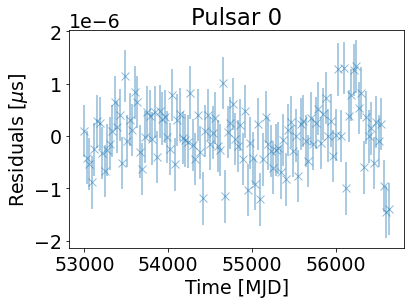

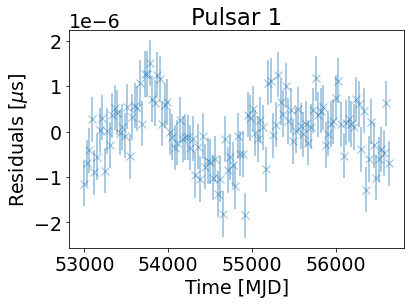

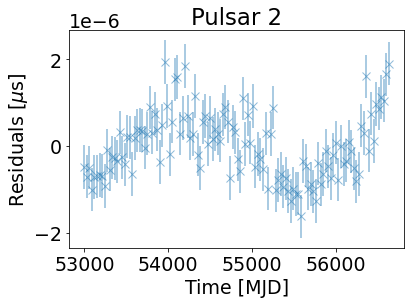

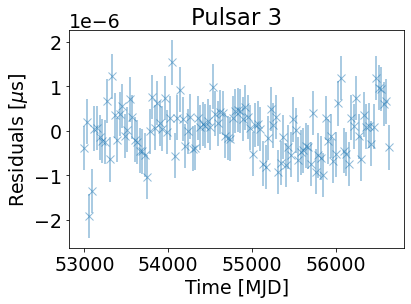

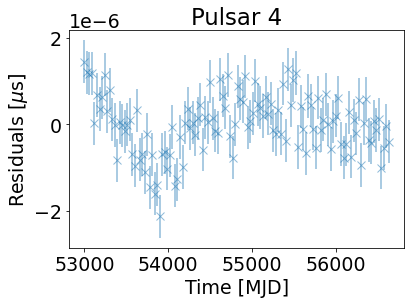

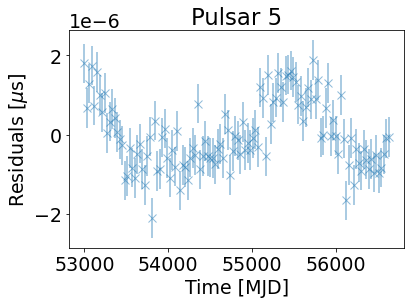

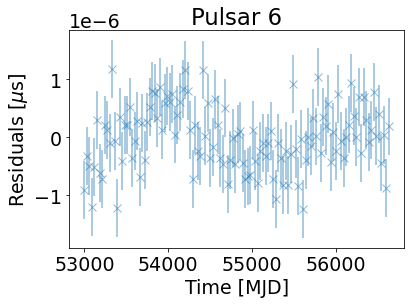

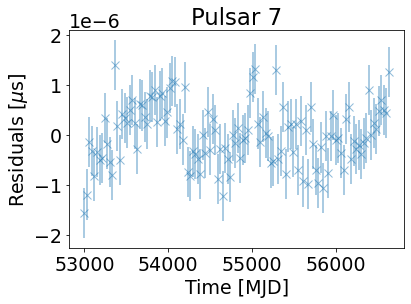

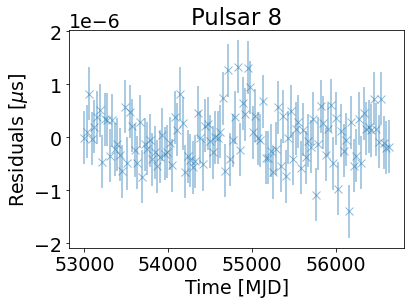

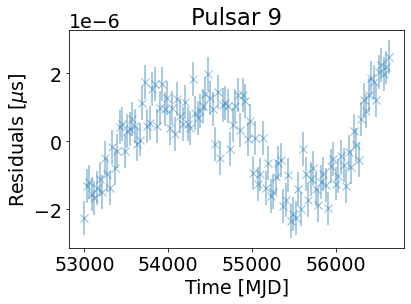

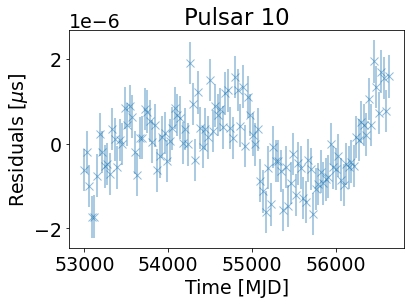

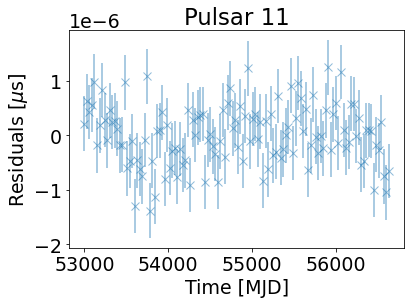

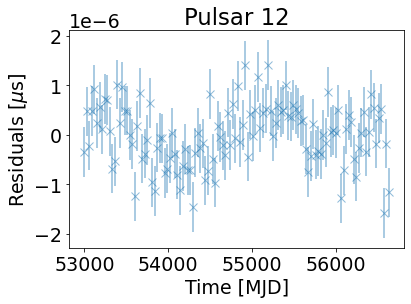

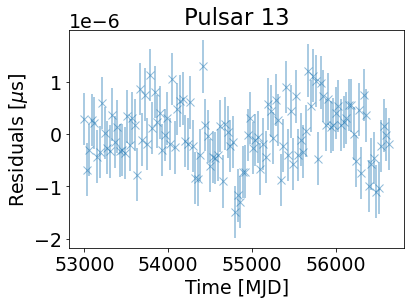

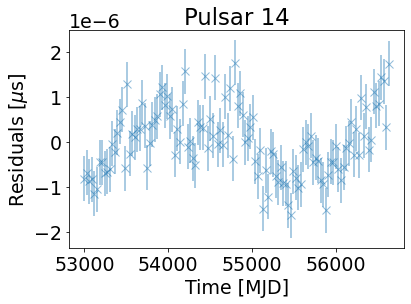

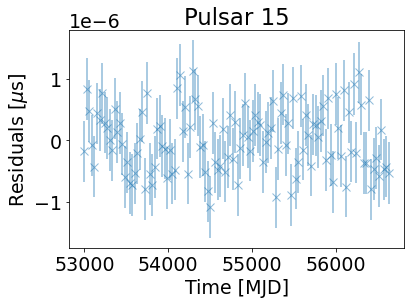

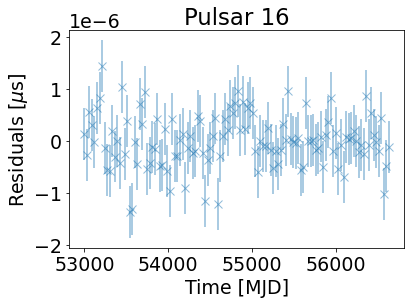

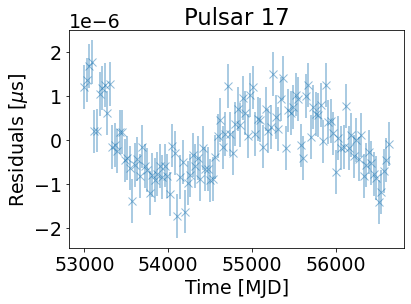

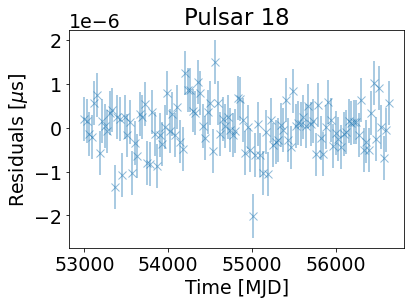

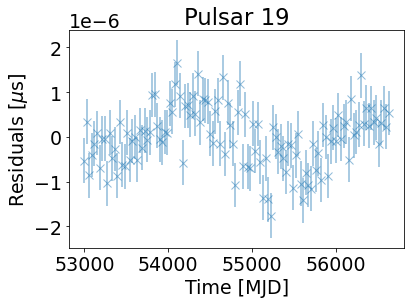

In [8]:
### Visualize data
for i, psr in enumerate(psrs):
#     resids = psr.residuals()
    plt.figure(i)      
    plt.errorbar(psr.toas/86400,
            psr.residuals,
            yerr=0.5*10**(-6),#psr.toaerrs[mk],
            markersize=8, ls='', marker='x', alpha=0.5)
    plt.xlabel('Time [MJD]')
    plt.ylabel(r'Residuals [$\mu$s]')
    plt.title('Pulsar {}'.format(i))
    plt.show()

In [3]:
pkl_path = "/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_13_3/"
with open(pkl_path + "Psrs_pkl.pkl", 'rb') as f:
    psrs = pickle.load(f)

In [5]:
#Truncate PTA based on Tspan > 10 years
keep_list = []
for p in psrs:
    if (p.toas.max()-p.toas.min())/86400/365 > 10:
        print(p.name)
        print((p.toas.max()-p.toas.min())/86400/365)
        keep_list.append(p)
print(len(keep_list))

0


In [21]:
# os.makedirs(pkl_path, exist_ok=True)
# with open(pkl_path + "Psrs_pkl_10yrs.pkl", 'wb') as f:
#     pickle.dump(keep_list, f)

In [7]:
# with open("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/QuickBurst_test_15yrAstro4Cast_parabolic_15Mpc_NoRN/Psrs_pkl_10yrs.pkl", 'rb') as f:
#     psrs = pickle.load(f)

In [25]:
psrs[0].flags.keys()

dict_keys(['pta'])

In [13]:
ng_frontends=['327', '430', 'Rcvr_800', 'Rcvr1_2', 'L-wide', 'S-wide', '1.5GHz', '3GHz']
for i, psr in enumerate(psrs):
    fe_masks = {}
    fe_resids = {}
    psr_fe = np.unique(psr.flags['fe'])
    resids = psr.residuals
    #plt.plot(psr.toas(),resids)
#     print(psr.name)
    plt.figure(i)
    for fe in ng_frontends:
        if fe in psr_fe:
            fe_masks[fe] = np.array(psr.flags['fe']==fe)
            mk = fe_masks[fe]
            plt.errorbar(psr.toas[mk],
                    psr.residuals[mk]*1e6,
                    yerr=0.0,#psr.toaerrs[mk],
                    markersize=8, ls='', marker='x', label=fe, alpha=0.5)
            plt.xlim(tref, maximum)
            plt.title(psr.name)
            #plt.axvline(psr.toas[0]+1423*(86400))
    plt.legend()
    plt.show()

KeyError: 'fe'

In [4]:
#Loading in pickle and noise files
#pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'

#15 year Astro 4Cast noise file
# noise_file = "/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/quickburst_test_15yrAstro4Cast_parabolic_3Mpc_60M/v1p1_all_dict.json"
# with open(noise_file, 'r') as h:
#     noise_params = json.load(h)
    
#20 pulsar simple noise file
noise_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/params_simulated.json"
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
    
gw_gamma = 3.9631095225441486 #13/3 #6.6
gw_amp = -14.045638789474289 #-14.22 #-14.6 #-16.27
### RUN IF USING SIMPLE 20 PULSAR DATASET W/ CURN
noise_params['gw_crn_gamma'] = gw_gamma
noise_params['gw_crn_log10_A'] = gw_amp

In [5]:
#del noise_params_sim['nmodel']
noise_params

{'JPSR00_efac': 1.0,
 'JPSR01_efac': 1.0,
 'JPSR02_efac': 1.0,
 'JPSR03_efac': 1.0,
 'JPSR04_efac': 1.0,
 'JPSR05_efac': 1.0,
 'JPSR06_efac': 1.0,
 'JPSR07_efac': 1.0,
 'JPSR08_efac': 1.0,
 'JPSR09_efac': 1.0,
 'JPSR10_efac': 1.0,
 'JPSR11_efac': 1.0,
 'JPSR12_efac': 1.0,
 'JPSR13_efac': 1.0,
 'JPSR14_efac': 1.0,
 'JPSR15_efac': 1.0,
 'JPSR16_efac': 1.0,
 'JPSR17_efac': 1.0,
 'JPSR18_efac': 1.0,
 'JPSR19_efac': 1.0,
 'JPSR00_log10_equad': -17,
 'JPSR01_log10_equad': -17,
 'JPSR02_log10_equad': -17,
 'JPSR03_log10_equad': -17,
 'JPSR04_log10_equad': -17,
 'JPSR05_log10_equad': -17,
 'JPSR06_log10_equad': -17,
 'JPSR07_log10_equad': -17,
 'JPSR08_log10_equad': -17,
 'JPSR09_log10_equad': -17,
 'JPSR10_log10_equad': -17,
 'JPSR11_log10_equad': -17,
 'JPSR12_log10_equad': -17,
 'JPSR13_log10_equad': -17,
 'JPSR14_log10_equad': -17,
 'JPSR15_log10_equad': -17,
 'JPSR16_log10_equad': -17,
 'JPSR17_log10_equad': -17,
 'JPSR18_log10_equad': -17,
 'JPSR19_log10_equad': -17,
 'gw_crn_gamma': 3.9

In [14]:
#Edit equad to have keys including 't2equad'
#only needed for converting 12.5yr data to current enterprise structure
noise_dict = {}
for k, v in noise_params.items():
    if 'equad' in k:
        noise_dict[k[:-5] + 't2equad'] = v
    else:
        noise_dict[k] = v
noise_params = noise_dict

In [ ]:
# %%time

# tmin = 53216.1516728
# stop_time = 57781.7766728 #for 12.5yr slice

# psrs = []
# for i, (p, t) in enumerate(zip(parfiles[::], timfiles[::])):
#     print(p)
#     psr = Pulsar(p, t, ephem='DE436', clk=None)
#     psr.filter_data(start_time = 0.0, end_time = stop_time)
#     #Filtering out pulsars for < 3 years data
#     if (psr.toas.size == 0) or (enterprise_extensions.model_utils.get_tspan([psr]) < 3*365.25*24*3600):
#         print("Meh")
#         continue
#     else:
#     #Keeping other pulsars w/ > 3 years data
#         print("yeah")
#         psrs.append(psr)

# #Test whether the time-span for the new dataset is really 12.5-yr
# tspan = enterprise_extensions.model_utils.get_tspan(psrs)
# print(tspan / (365.25 * 24 * 3600))
# print(len(psrs))

In [ ]:
# print(len(psrs))

# #Injecting data into each pulsar
# for idx in range(len(psrs)):
#     plt.figure(idx)
#     injected_data = T2.tempopulsar(parfile = parfiles[idx], timfile = timfiles[idx], maxobs=30000, ephem='DE436',clk=None)
#     LP.plotres(injected_data, label='Data')
#     plt.xlim((tmin,stop_time))

In [9]:
psrs[0]

# Signal tau-scans

In [15]:
#Finding reference time for dataset
maximum = 0
minimum = np.inf
for psr in psrs:
    if psr.toas.max() > maximum:
        maximum = psr.toas.max()
    if psr.toas.min() < minimum:
        minimum = psr.toas.min()


#Sets reference time
tref = minimum

t0_max = (maximum - minimum)/365/24/3600
print(t0_max)

9.945234130667165


In [8]:
maximum/24/3600

56630.00644875535

In [9]:
minimum/24/3600

52999.995991061835

In [6]:
#PTA generation w/ 
os.chdir('/home/reyna/BayesHopperBurst/QuickBurst/')
import QuickBurst_MCMC_testing as QB_MCMC

In [16]:
#PTA generation w/ 
os.chdir('/home/reyna/BayesHopperBurst/QuickBurst/')
import QuickBurst_MCMC_testing as QB_MCMC
x = QB_MCMC.get_pta(psrs, vary_white_noise=False, include_efac = True, include_equad=True,
                        include_ecorr = False, wn_backend_selection=False,
                        noisedict=noise_params, include_rn=True, vary_rn=False,
                        include_per_psr_rn=False, vary_per_psr_rn=False,
                        max_n_wavelet=5, efac_start = None, rn_amp_prior='log-uniform',
                        rn_log_amp_range=[-18,-15], rn_params=[-13.0,1.0], per_psr_rn_amp_prior='log-uniform',
                        per_psr_rn_log_amp_range=[-18,-11], wavelet_amp_prior='uniform',
                        wavelet_log_amp_range=[-10.0,-5], prior_recovery=False,
                        max_n_glitch=5, glitch_amp_prior='uniform', glitch_log_amp_range=[-10.0,-5],
                        t0_min=0.0, t0_max=t0_max, f0_min=3.5e-9, f0_max=1e-7,
                        TF_prior=None, tref=tref)


get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR00_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR00_measurement_noise                 MeasurementNoise               0                   

params:
JPSR00_efac:Constant=1.0                                                                  
JPSR00_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR00_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095225441486                                      

In [ ]:
noise_params

In [ ]:
len(x[0].params)

In [12]:
TauScan = tau_scans_pta.TauScan(psrs, params=noise_params, pta=x[0])

In [ ]:
# #
# # efac_params = {psr_name+"_efac":1.0 for idx, psr_name in enumerate(psrlist)}

# # equad_params = {psr_name+"_log10_equad":-17 for idx, psr_name in enumerate(psrlist)} #basically setting to 0

# params = {**efac_params, **equad_params}
# print(params)

# #noisedict_file = "/home/reyna/BayesHopperBurst/BenceData/channelized_12p5yr_v3_full_noisedict_BayesHopperBurst.json"
# noisedict_file = noise_file

# # pta = BayesHopperBurst.get_ptas(psrs, noisedict_file=noisedict_file,
# #                                 vary_white_noise=False, include_per_psr_rn=False, include_rn=False,
# #                                 include_gwb=False)[0][0][0] #can very depending on the data

# print(pta.summary())

# #TauScan = tau_scans_pta.TauScan([psrs[2],], params=params)
# #TauScan = tau_scans_pta.TauScan([psrs[0],], params=params)
# TauScan = tau_scans_pta.TauScan(psrs, params=params, pta=pta)
# #TauScan = tau_scans_pta.TauScan(psrs[:4], params=params)

# Noise transient tau-scans

In [17]:
#t_res = 100
#f_res = 50
#tau_res = 10

#original
f_max = 1e-7
f_min = 3.5e-9 #1e-8
#narrow f
#f_max = 10**(-7.5)
#f_min = 1e-8
#narrow f2
#f_max = 1e-8
#f_min = 10**(-8.25)

#original
t_max = t0_max
t_min = 0.0
#zoom in 1
#t_max = 12.5
#t_min = 0.41666667
#zoom in 2
#t_max = 12.5
#t_min = 8.0
#narrow_f2
#t_max = 12.5
#t_min = 2.0

tau_min = 0.2
tau_max = 5.0 #3.0

In [18]:
1/(tau_max*365*24*3600)

6.341958396752917e-09

In [14]:
os.chdir('/home/reyna/BayesHopperBurst/QuickBurst/')
import QuickBurst_MCMC_testing as QB_MCMC

# Individual glitch tau scans

In [20]:
#%%time
TS_all = {}
tau_scan = 0
for i in range(len(psrs)):
#     if i == 0:
#         continue
#     if i == 1:
#         continue
#         if 'J1713' in psrs[i].name:
#     noisedict_file = "/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/quickburst_test_15yrAstro4Cast_parabolic_3Mpc_60M/v1p1_all_dict.json"

    x = QB_MCMC.get_pta([psrs[i],], vary_white_noise=False, include_equad=True,
                            include_ecorr = False, include_efac = True, 
                            wn_backend_selection=False, noisedict=noise_dict, include_rn=True,
                            vary_rn=False, include_per_psr_rn=False, vary_per_psr_rn=False,
                            max_n_wavelet=5, efac_start = None, rn_amp_prior='log-uniform',
                            rn_log_amp_range=[-18,-15], rn_params=[gw_amp, gw_gamma], per_psr_rn_amp_prior='log-uniform',
                            per_psr_rn_log_amp_range=[-18,-11], gwb_amp_prior='uniform',
                            gwb_log_amp_range=[-18, -11], wavelet_amp_prior='uniform',
                            wavelet_log_amp_range=[-10.0,-5], prior_recovery=False,
                            max_n_glitch=1, glitch_amp_prior='uniform', glitch_log_amp_range=[-10.0,-5],
                            t0_min=0.0, t0_max=t0_max, f0_min=f_min, f0_max=f_max,
                            TF_prior=None, tref=tref)

#     print(x[0].summary())

    #Performs tau scans for each pulsar individually (noise transients)

    TauScan = tau_scans_pta.TauScan([psrs[i],], params=noise_params, pta=x[0])
    TS_dict = tau_scans_pta.make_tau_scan_map(TauScan, f_min=f_min, f_max=f_max, t_min=t_min, t_max=t_max,
                                tau_min=tau_min, tau_max=tau_max)
    TS_all['tau_edges'] = TS_dict['tau_edges'] #why saved every time?
    TS_all['t0_edges'] = TS_dict['t0_edges']
    TS_all['f0_edges'] = TS_dict['f0_edges']
    TS_all['tau_scan'+str(i)] = TS_dict['tau_scan']

    #Stitch together all individual tau scans (wavelets)
#     if i == 0:
#         tau_scan = TS_dict['tau_scan']
#         tau_edges = TS_dict['tau_edges']
#         T0_list = TS_dict['t0_edges']
#         F0_list = TS_dict['f0_edges']
#     else:
#         for j in range(len(TS_dict['tau_scan'])):
#             #print(TS_dict['tau_scan'][j].shape)
#             #print(glitch_tau_scan_data['tau_scan'][j].shape)
#             #TS_dict['tau_scan'][j] += glitch_tau_scan_data['tau_scan'][j]
#             #TS_dict['tau_scan'][j] += glitch_tau_scan_data[tau_scan_key][j]
#             ts = TS_dict['tau_scan'][j]
#             tau_scan[j] += np.where(np.isnan(ts), 0.0, ts)
#             if np.isnan(np.max(ts)):
#                 print(tau_scan_key)
#                 print(ts)

get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR00_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR00_measurement_noise                 MeasurementNoise               0                   

params:
JPSR00_efac:Constant=1.0                                                                  
JPSR00_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR00_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095225441486                                      

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR01_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR01_measurement_noise                 MeasurementNoise               0                   

params:
JPSR01_efac:Constant=1.0                                                                  
JPSR01_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR01_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR02_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR02_measurement_noise                 MeasurementNoise               0                   

params:
JPSR02_efac:Constant=1.0                                                                  
JPSR02_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR02_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR03_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR03_measurement_noise                 MeasurementNoise               0                   

params:
JPSR03_efac:Constant=1.0                                                                  
JPSR03_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR03_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR04_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR04_measurement_noise                 MeasurementNoise               0                   

params:
JPSR04_efac:Constant=1.0                                                                  
JPSR04_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR04_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR05_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR05_measurement_noise                 MeasurementNoise               0                   

params:
JPSR05_efac:Constant=1.0                                                                  
JPSR05_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR05_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR06_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR06_measurement_noise                 MeasurementNoise               0                   

params:
JPSR06_efac:Constant=1.0                                                                  
JPSR06_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR06_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR07_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR07_measurement_noise                 MeasurementNoise               0                   

params:
JPSR07_efac:Constant=1.0                                                                  
JPSR07_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR07_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289        

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR08_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR08_measurement_noise                 MeasurementNoise               0                   

params:
JPSR08_efac:Constant=1.0                                                                  
JPSR08_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR08_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR09_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR09_measurement_noise                 MeasurementNoise               0                   

params:
JPSR09_efac:Constant=1.0                                                                  
JPSR09_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR09_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR10_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR10_measurement_noise                 MeasurementNoise               0                   

params:
JPSR10_efac:Constant=1.0                                                                  
JPSR10_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR10_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR11_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR11_measurement_noise                 MeasurementNoise               0                   

params:
JPSR11_efac:Constant=1.0                                                                  
JPSR11_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR11_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR12_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR12_measurement_noise                 MeasurementNoise               0                   

params:
JPSR12_efac:Constant=1.0                                                                  
JPSR12_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR12_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR13_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR13_measurement_noise                 MeasurementNoise               0                   

params:
JPSR13_efac:Constant=1.0                                                                  
JPSR13_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR13_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR14_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR14_measurement_noise                 MeasurementNoise               0                   

params:
JPSR14_efac:Constant=1.0                                                                  
JPSR14_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR14_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR15_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR15_measurement_noise                 MeasurementNoise               0                   

params:
JPSR15_efac:Constant=1.0                                                                  
JPSR15_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR15_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR16_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR16_measurement_noise                 MeasurementNoise               0                   

params:
JPSR16_efac:Constant=1.0                                                                  
JPSR16_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR16_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR17_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR17_measurement_noise                 MeasurementNoise               0                   

params:
JPSR17_efac:Constant=1.0                                                                  
JPSR17_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR17_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_gamma:Constant=3.9631095

2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR18_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR18_measurement_noise                 MeasurementNoise               0                   

params:
JPSR18_efac:Constant=1.0                                                                  
JPSR18_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR18_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                               

3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
get_pta ent_lnlike_test:  False
enterprise v3.3.3,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
JPSR19_linear_timing_model_svd           TimingModel                    0                   

params:
__________________________________________________________________________________________
JPSR19_measurement_noise                 MeasurementNoise               0                   

params:
JPSR19_efac:Constant=1.0                                                                  
JPSR19_log10_t2equad:Constant=-17                                                         
__________________________________________________________________________________________
JPSR19_com_rn                            FourierBasisGP                 0                   

params:
gw_crn_log10_A:Constant=-14.045638789474289                                               
gw_crn_

4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462


In [40]:
TS_all['tau_scan0']

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.98814522e+00, 1.98802657e+00, 1.98793898e+00,
         1.98785451e+00, 1.98770764e+00, 1.98790877e+00, 1.98775223e+00,
         1.98766717e+00, 1.98758026e+00, 1.98738466e+00, 1.98760610e+00,
         1.98747850e+00, 1.98739502e+00, 1.98730451e+00, 1.98698185e+00,
         1.98731629e+00, 1.98720514e+00, 1.98712251

# Saving individual glitch tau scans

In [21]:
# with open("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/simple_glitch_tau_scan_CURN_fix.pkl", 'wb') as f:
#     pickle.dump(TS_all, f)

In [5]:
# with open("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/60Mpc_parabolic_flyby/RN/glitch_tauscan_15yr-Astro4Cast_parabolic_60Mpc_RN.pkl", 'rb') as f:
#     TS_all = pickle.load(f)

# Stitching together individual glitch tau scans and saving combined tau scan

In [13]:
TS_all.keys()

dict_keys(['tau_edges', 't0_edges', 'f0_edges', 'tau_scan0', 'tau_scan1', 'tau_scan2', 'tau_scan3', 'tau_scan4', 'tau_scan5', 'tau_scan6', 'tau_scan7', 'tau_scan8', 'tau_scan9', 'tau_scan10', 'tau_scan11', 'tau_scan12', 'tau_scan13', 'tau_scan14', 'tau_scan15', 'tau_scan16', 'tau_scan17', 'tau_scan18', 'tau_scan19'])

In [22]:
#glitch_tauscan_pickles = glob.glob("../SimDataResults/glitch_tauscan_parabolic_*.pkl")
#glitch_tauscan_pickles = glob.glob("../sglpsr_tauscans/glitch_tauscan_nano15yr_v1p1_RN_*")

TS_dict = {}

for i in range(len(psrs)):
#     if i == 0:
#         continue
#     if i == 1:
#         continue
#     glitch_tau_scan_file = glitch_tauscan_pickles[i]
#     with open(glitch_tau_scan_file, 'rb') as f:
#         glitch_tau_scan_data = pickle.load(f)
    
    glitch_tau_scan_data = np.copy(TS_all['tau_scan{}'.format(i)])
#     print(TS_dict)
#     print(TS_all['tau_scan{}'.format(0)])
    #tau_scan_key = [key for key in list(glitch_tau_scan_data.keys()) if 'tau_scan' in key][0]
    #print(tau_scan_key)
    
    #if tau_scan_key=='tau_scan38':
    #    print("nan found in tauscan - skipping this pulsar")
    #    continue
    
    #Only populate tau edges, f0, t0 once. Same for all pulsars
    print('Pulsar {}'.format(i))
    if i==0:
        TS_dict['tau_edges'] = TS_all['tau_edges']
        TS_dict['f0_edges'] = TS_all['f0_edges']
        TS_dict['t0_edges'] = TS_all['t0_edges']
    
        #TS_dict['tau_scan'] = glitch_tau_scan_data['tau_scan']
        TS_dict['tau_scan'] = glitch_tau_scan_data
#     elif i == 63:
#         print('YES')
#         print(glitch_tau_scan_data[2])
    
    #Otherwise, stitch together tau scans for each pulsar to get wavelet tau scans
    else:
        for j in range(len(TS_dict['tau_scan'])):
            print('Bin: {}'.format(j))
            #print(TS_dict['tau_scan'][j].shape)
            #print(glitch_tau_scan_data['tau_scan'][j].shape)
            #TS_dict['tau_scan'][j] += glitch_tau_scan_data['tau_scan'][j]
            #TS_dict['tau_scan'][j] += glitch_tau_scan_data[tau_scan_key][j]
            ts = glitch_tau_scan_data
            TS_dict['tau_scan'][j] += np.where(np.isnan(ts[j]), 0.0, ts[j])
#             if np.isnan(np.max(ts[j])):
#                 print(tau_scan_key)
#                 print(glitch_tau_scan_file)
            #print(np.max(glitch_tau_scan_data[tau_scan_key][j]))
            #print(np.min(glitch_tau_scan_data[tau_scan_key][j]))
            print(np.max(TS_dict['tau_scan'][j]))
        print('\n')

Pulsar 0
Pulsar 1
Bin: 0
14.090525775941956
Bin: 1
13.253826116871604
Bin: 2
12.949528098612728
Bin: 3
12.21195426706289
Bin: 4
11.25916478191095


Pulsar 2
Bin: 0
18.486487140920865
Bin: 1
23.910988378518425
Bin: 2
23.678181501106156
Bin: 3
24.07330928190642
Bin: 4
22.135895330095856


Pulsar 3
Bin: 0
25.462623688185076
Bin: 1
28.090086804460732
Bin: 2
28.111585573093617
Bin: 3
27.408779450177857
Bin: 4
24.17891578383122


Pulsar 4
Bin: 0
29.923572481684406
Bin: 1
30.266948201610905
Bin: 2
28.60724210487474
Bin: 3
28.805174303306902
Bin: 4
26.533935076229223


Pulsar 5
Bin: 0
36.59981433485007
Bin: 1
35.47050693031498
Bin: 2
32.51611236147354
Bin: 3
31.91644347482267
Bin: 4
27.589293104771038


Pulsar 6
Bin: 0
39.70561433866278
Bin: 1
38.405639376641865
Bin: 2
35.0893321299028
Bin: 3
32.700211368744085
Bin: 4
30.13589295586602


Pulsar 7
Bin: 0
42.987683892817394
Bin: 1
41.43279238217453
Bin: 2
36.34020744704139
Bin: 3
35.13838273345398
Bin: 4
31.66256080806508


Pulsar 8
Bin: 0
44.04

/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [7]:
TS_dict

{'tau_edges': array([0.2       , 0.38073079, 0.72477966, 1.37972966, 2.6265278 ,
        5.        ]),
 'f0_edges': [array([3.50e-09, 2.28e-08, 4.21e-08, 6.14e-08, 8.07e-08, 1.00e-07]),
  array([3.50000000e-09, 1.22727273e-08, 2.10454545e-08, 2.98181818e-08,
         3.85909091e-08, 4.73636364e-08, 5.61363636e-08, 6.49090909e-08,
         7.36818182e-08, 8.24545455e-08, 9.12272727e-08, 1.00000000e-07]),
  array([3.50000000e-09, 8.09523810e-09, 1.26904762e-08, 1.72857143e-08,
         2.18809524e-08, 2.64761905e-08, 3.10714286e-08, 3.56666667e-08,
         4.02619048e-08, 4.48571429e-08, 4.94523810e-08, 5.40476190e-08,
         5.86428571e-08, 6.32380952e-08, 6.78333333e-08, 7.24285714e-08,
         7.70238095e-08, 8.16190476e-08, 8.62142857e-08, 9.08095238e-08,
         9.54047619e-08, 1.00000000e-07]),
  array([3.50000e-09, 5.91250e-09, 8.32500e-09, 1.07375e-08, 1.31500e-08,
         1.55625e-08, 1.79750e-08, 2.03875e-08, 2.28000e-08, 2.52125e-08,
         2.76250e-08, 3.00375e-08, 3.

In [ ]:
# TS_wave_dict = {}
# for k, v in TS_dict.items():
#     if k != 'tau_scan':
#         TS_wave_dict[k] = v
#     else:
#         TS_wave_dict[k] = tau_scan
# TS_wave_dict

# Saving stitched together tau scans (i.e. Wavelet tau scans)

In [23]:
# with open("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN_largeA_13_3_skyshift/simple_wavelet_tau_scan_CURN_fix.pkl", 'wb') as f:
#     pickle.dump(TS_dict, f)

In [7]:
#IF LOADING TO LOOK AT TAU SCANS, RUN THIS FOR WAVELET PLOTS ONLY
with open("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/Simple_20Psr_30Mpc_parabolic_flyby/CURN/simple_wavelet_tau_scan_fixed_NaNs.pkl", 'rb') as f:
    TS_dict = pickle.load(f)

In [9]:
#IF LOADING TO LOOK AT GLITCH TAU SCANS, RUN THIS FOR GLITCH PLOTS ONLY
with open("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Data/Paper_Datasets/30Mpc_parabolic_flyby/noRN/glitch_tauscan_15yr-Astro4Cast_parabolic_30Mpc_NoRN.pkl", 'rb') as f:
    TS_all = pickle.load(f)

# Plotting glitch tau scans

In [16]:
psrs[62].name

'J2234+0611'

dict_keys(['tau_edges', 't0_edges', 'f0_edges', 'tau_scan0', 'tau_scan1', 'tau_scan2', 'tau_scan3', 'tau_scan4', 'tau_scan5', 'tau_scan6', 'tau_scan7', 'tau_scan8', 'tau_scan9', 'tau_scan10', 'tau_scan11', 'tau_scan12', 'tau_scan13', 'tau_scan14', 'tau_scan15', 'tau_scan16', 'tau_scan17', 'tau_scan18', 'tau_scan19'])
0
100.47682316498467
1
10.166942240015793
2
23.570610623029616
3
14.286853839756503
4
12.39377096150387


/tmp/ipykernel_2593/2534833706.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(l+i*(tau_edges.size-1))


5
11.288589049761535
6
8.573501176617285
7
15.725976481117812
8
10.570634221240379
9
11.671861078698733
10
15.114765888444678
11
11.091398087414689
12
16.874348874676933
13
15.176479908617132
14
16.190037367531716
15
11.195980530845139
16
17.51358528683391
17
9.911496762332309
18
13.835116434134292
19
10.896020699957027


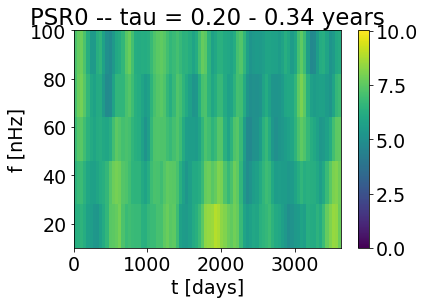

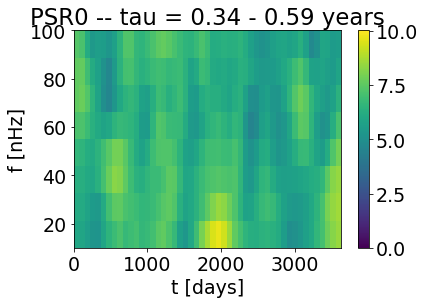

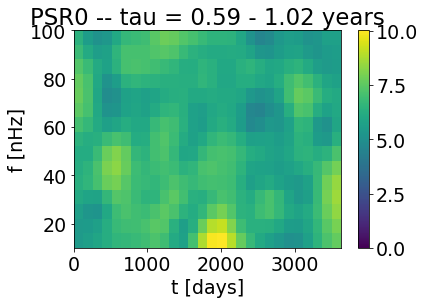

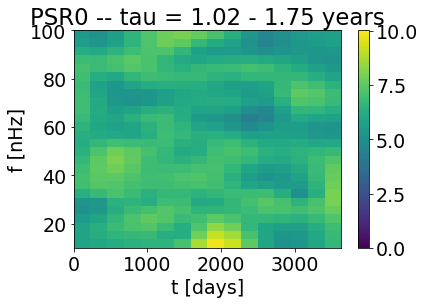

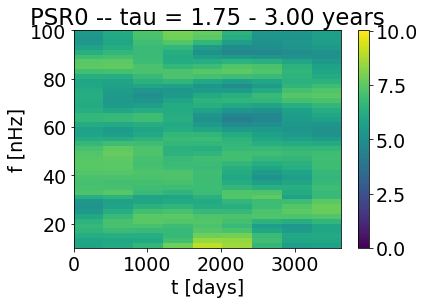

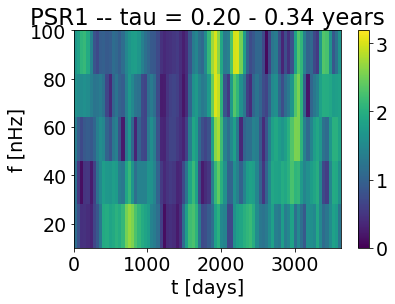

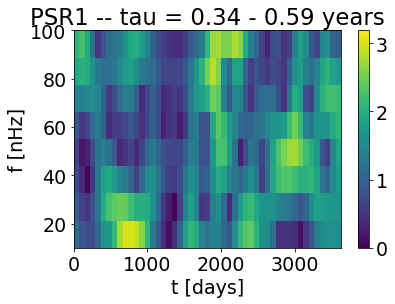

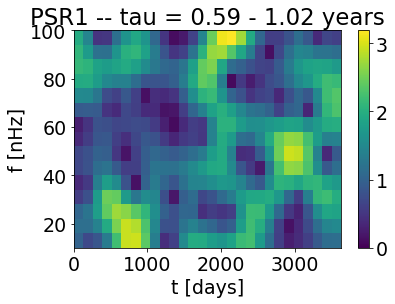

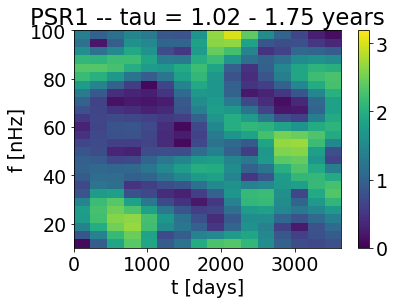

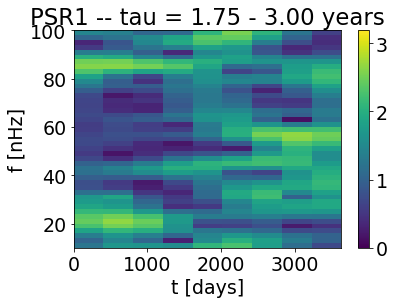

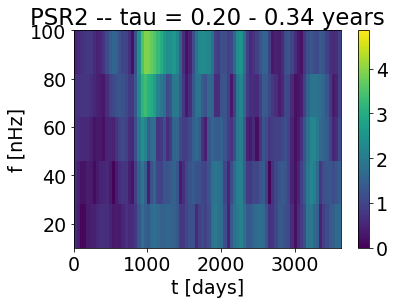

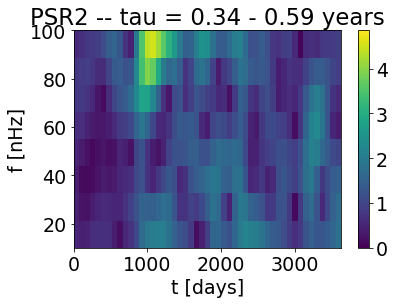

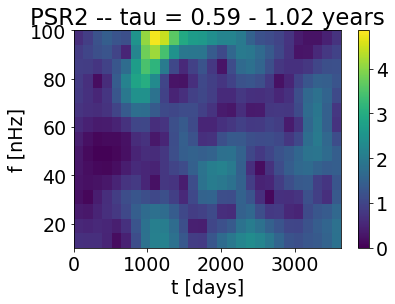

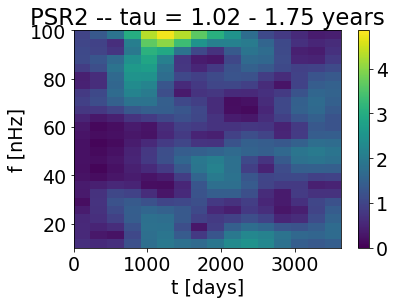

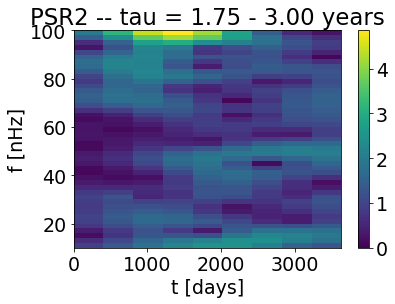

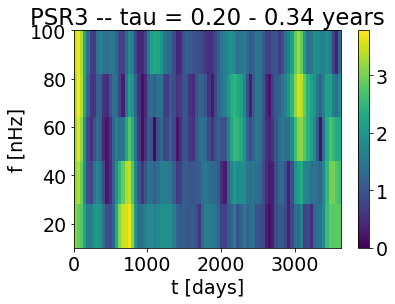

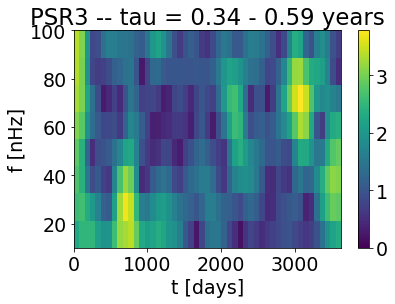

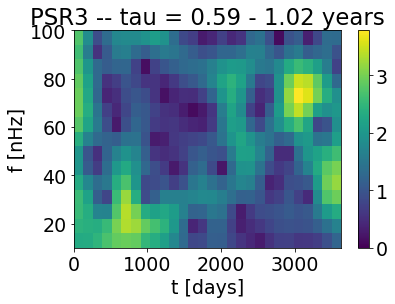

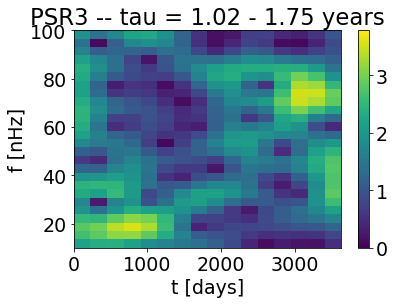

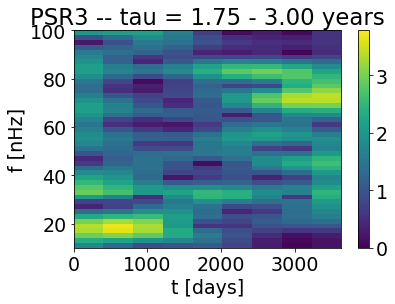

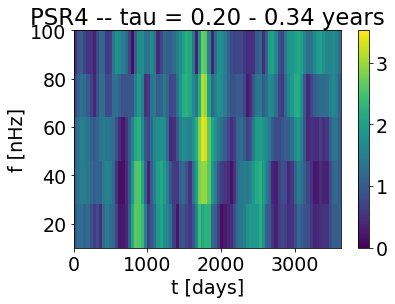

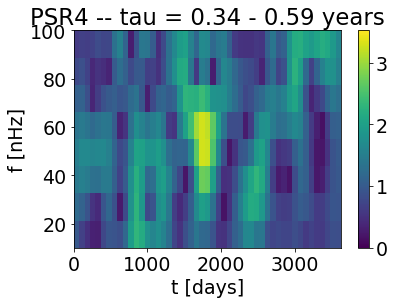

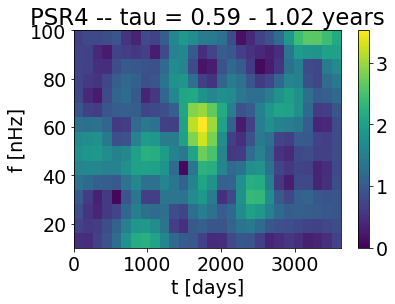

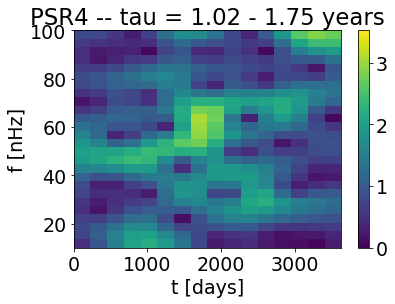

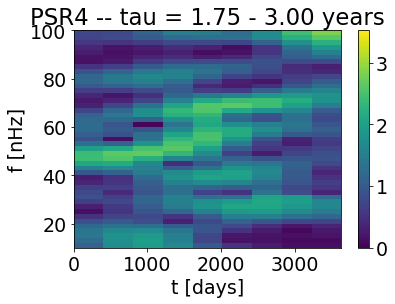

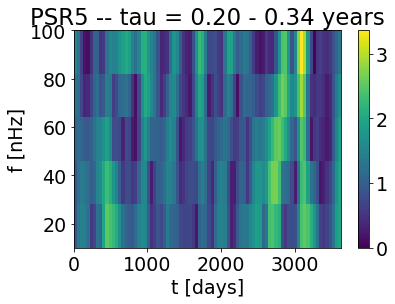

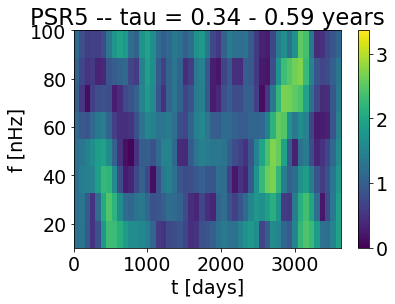

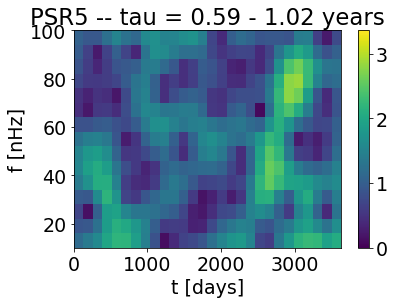

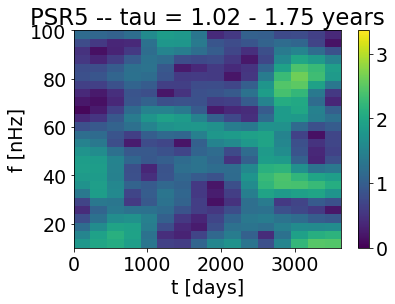

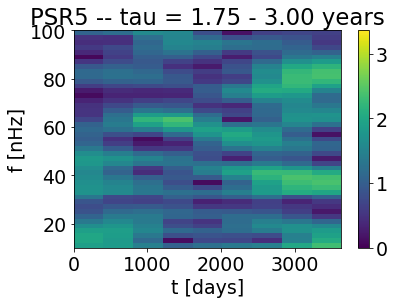

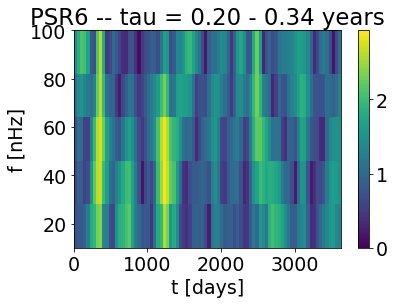

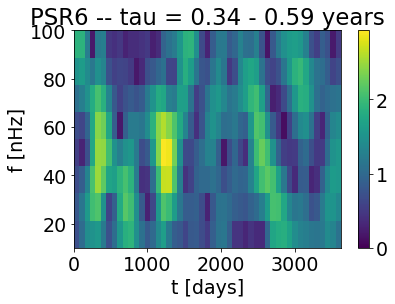

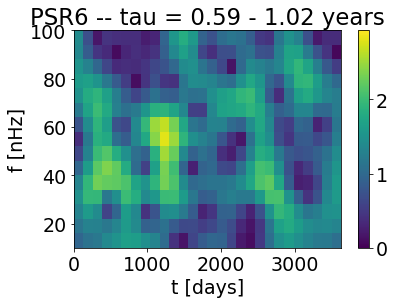

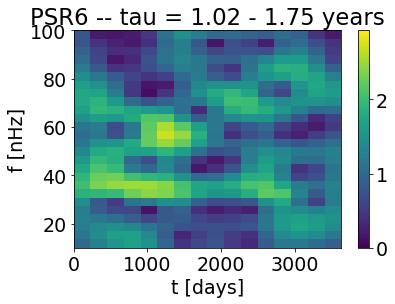

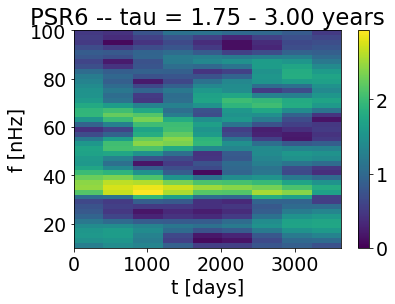

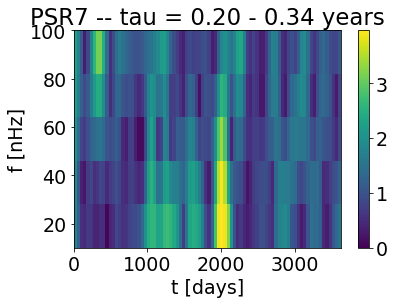

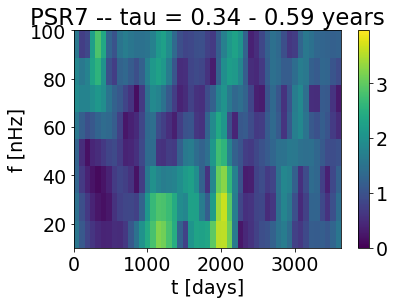

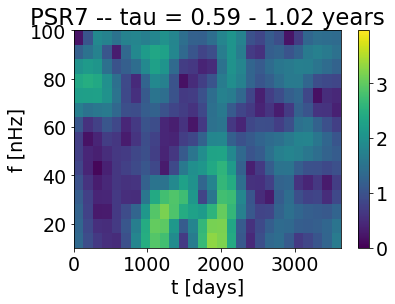

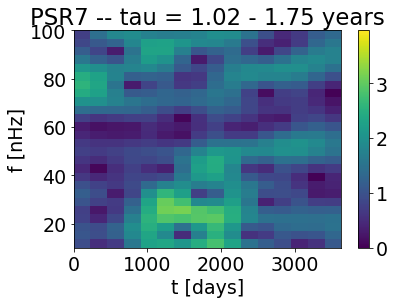

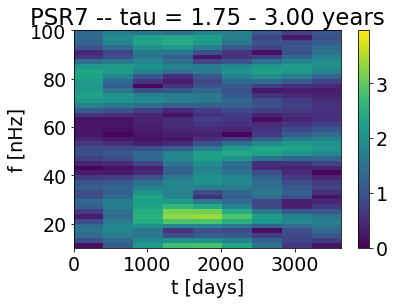

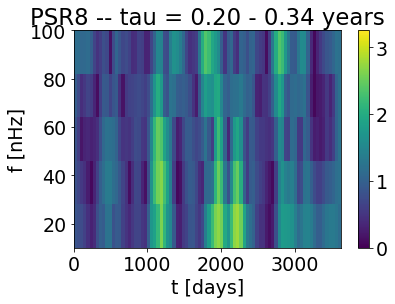

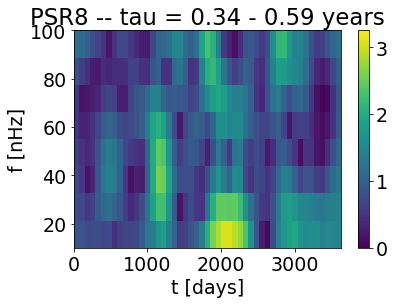

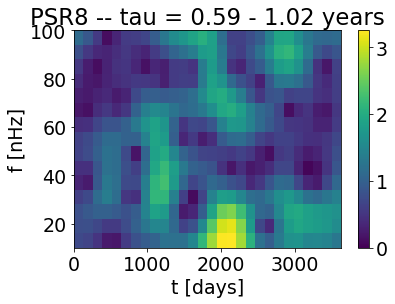

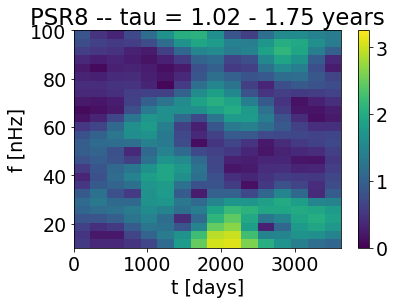

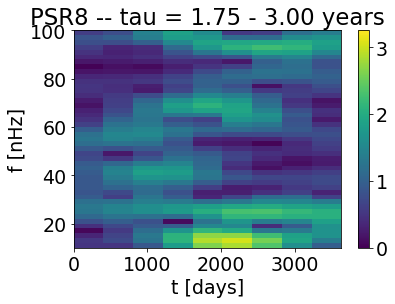

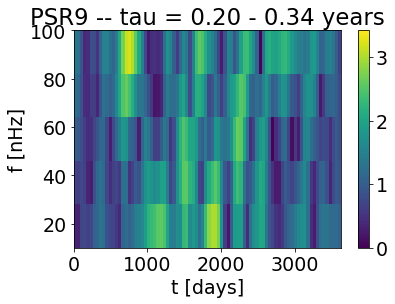

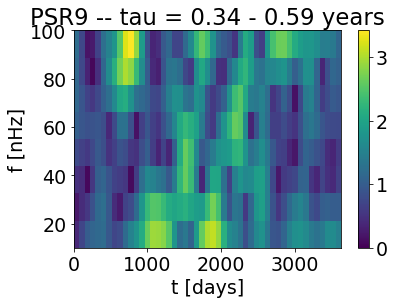

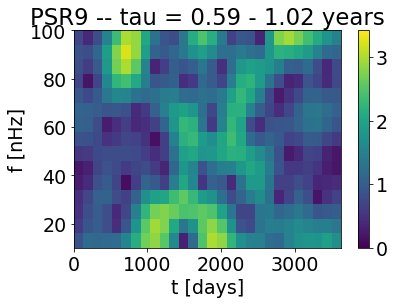

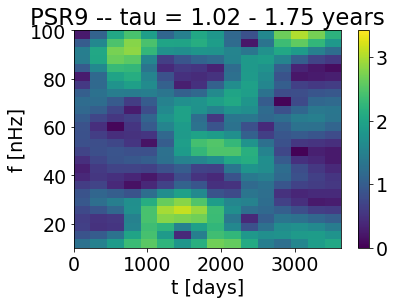

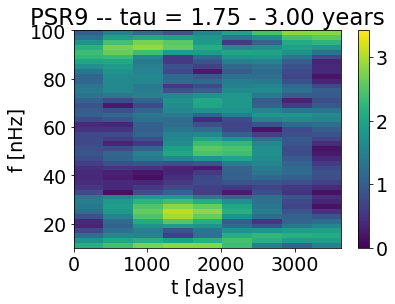

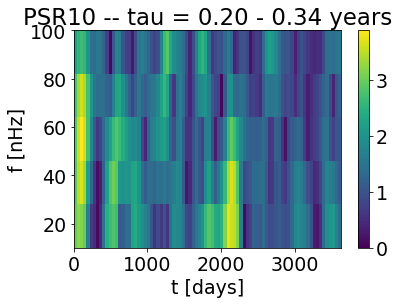

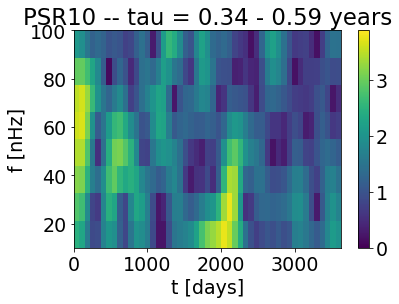

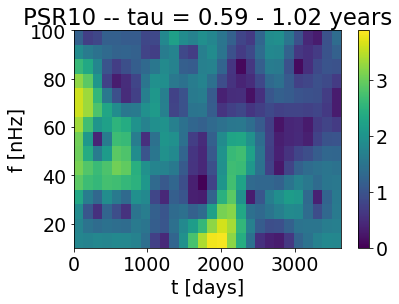

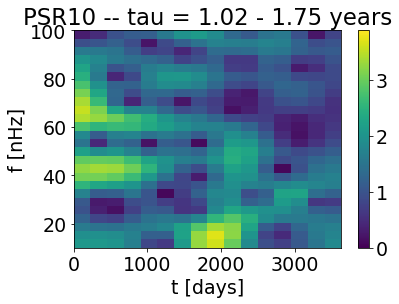

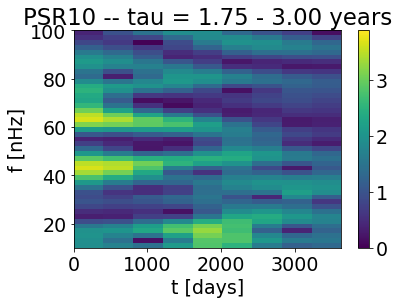

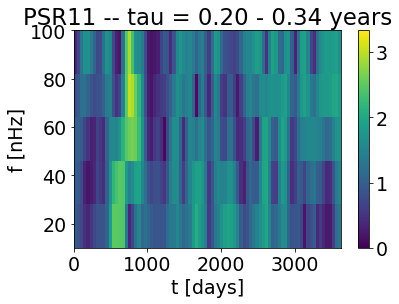

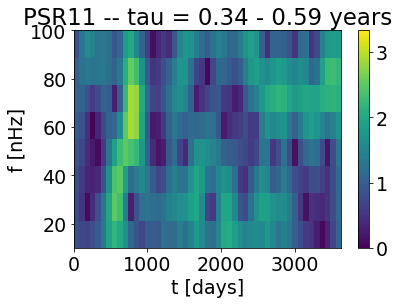

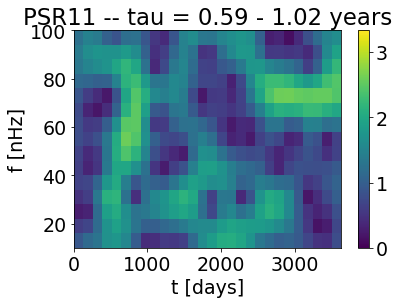

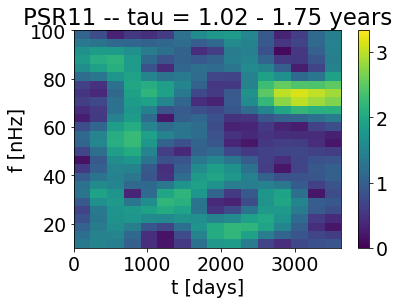

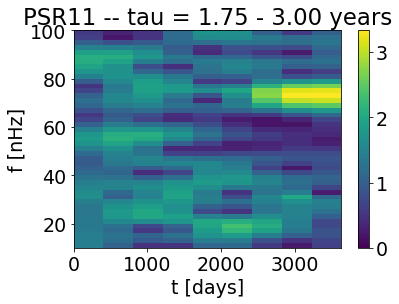

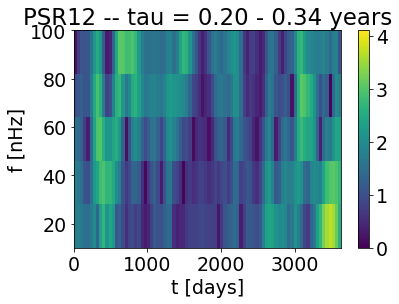

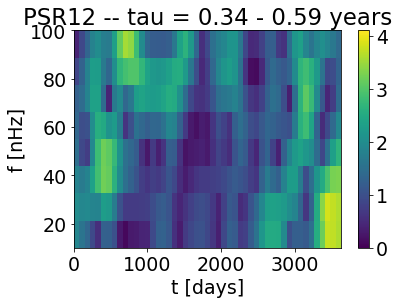

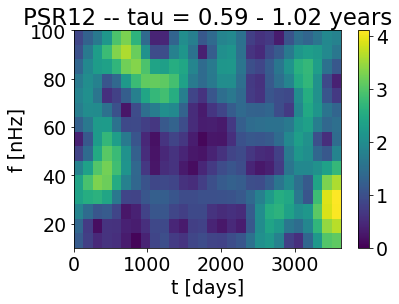

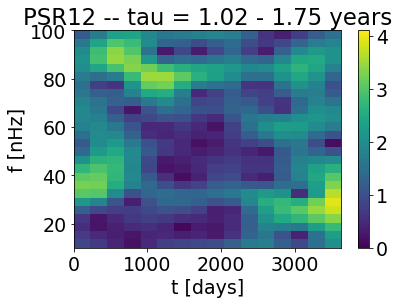

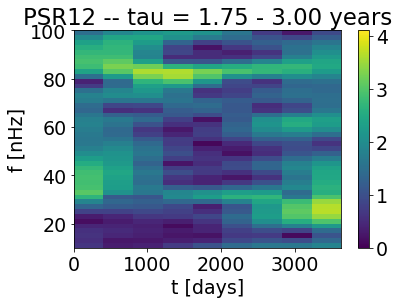

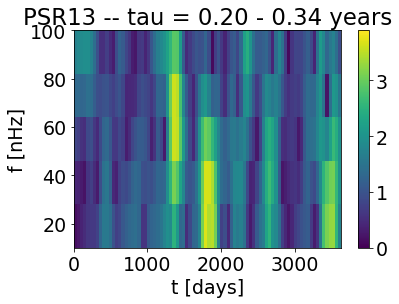

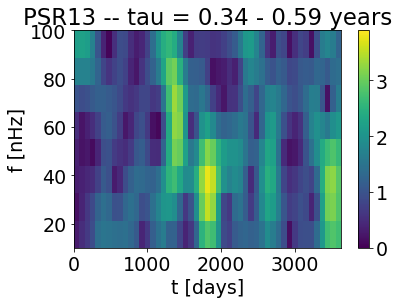

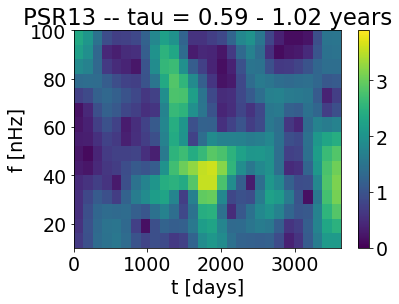

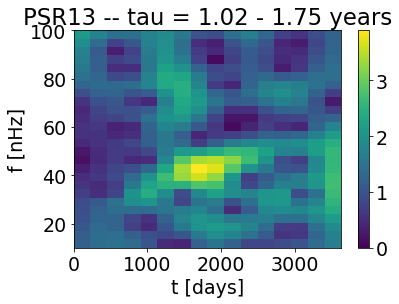

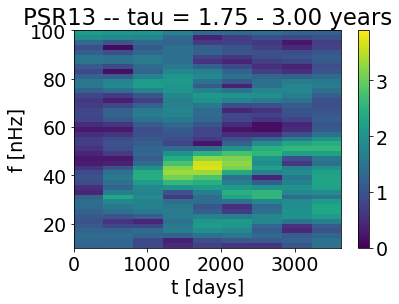

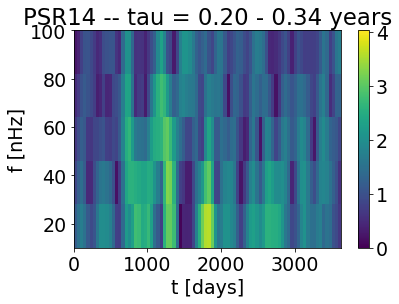

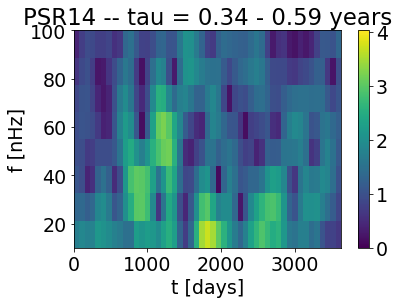

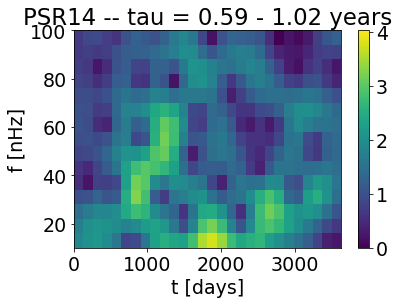

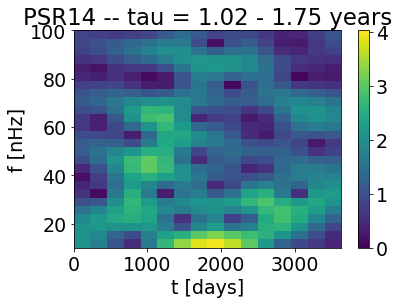

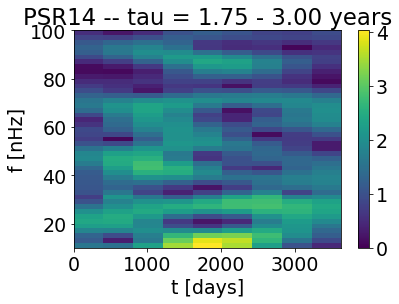

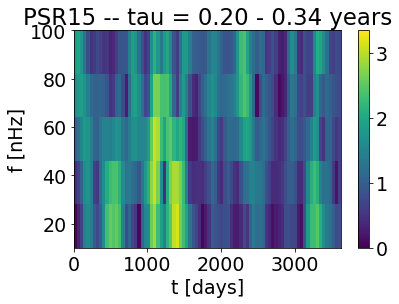

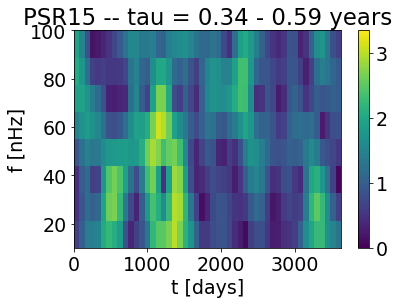

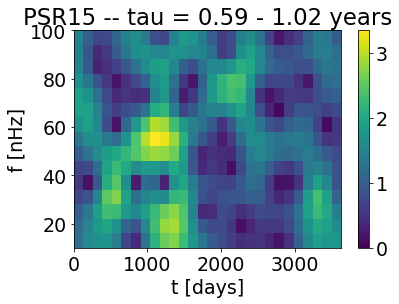

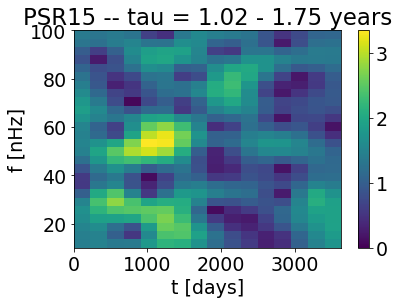

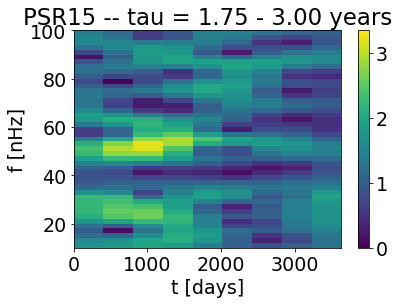

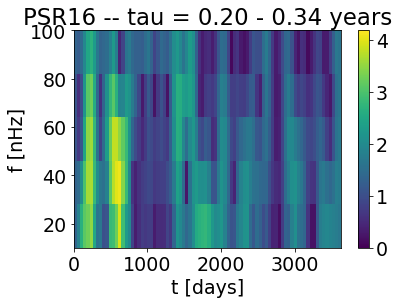

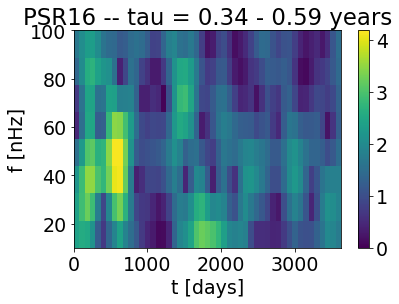

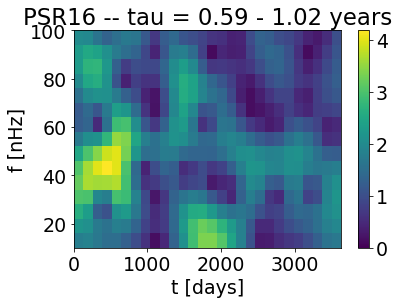

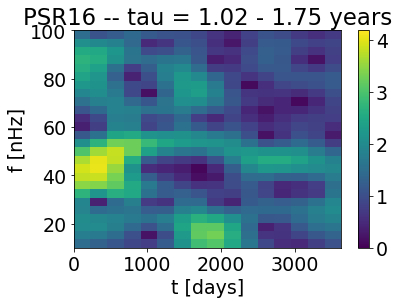

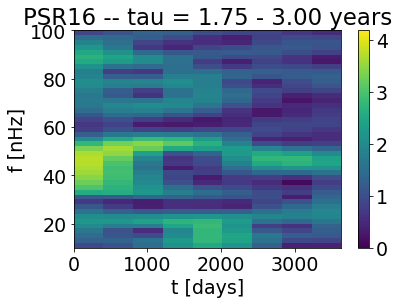

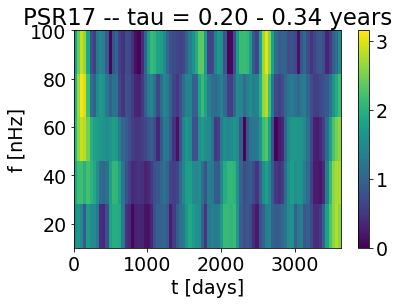

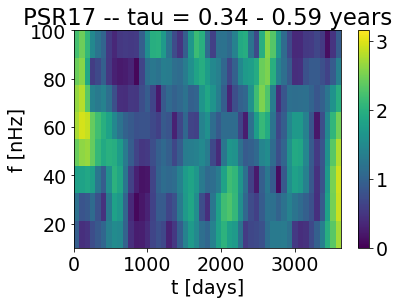

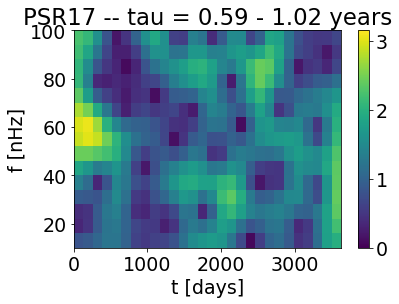

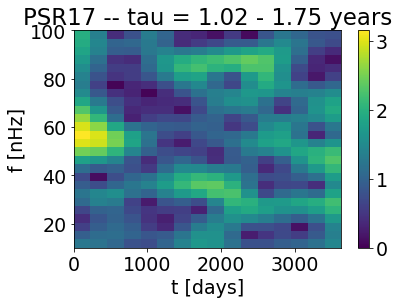

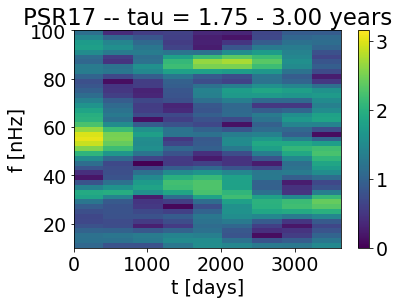

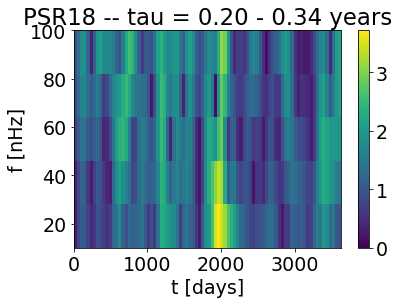

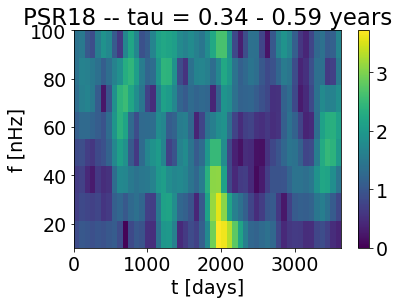

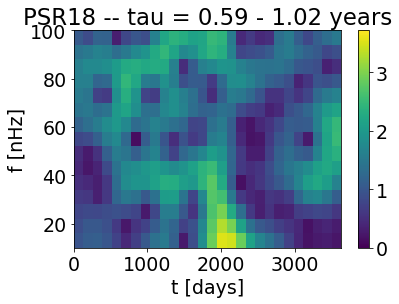

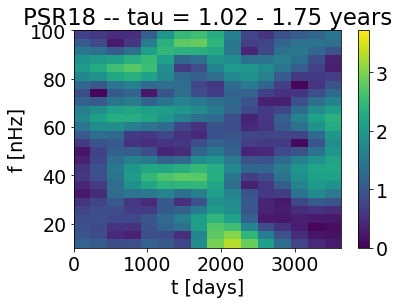

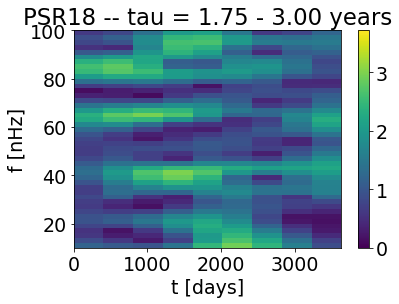

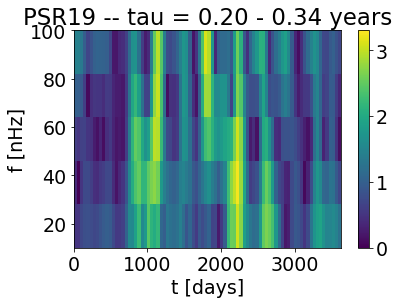

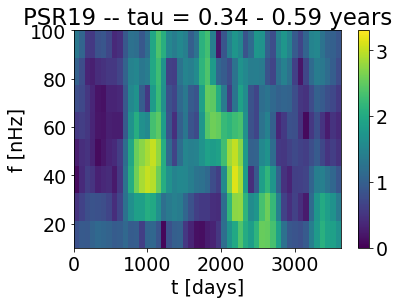

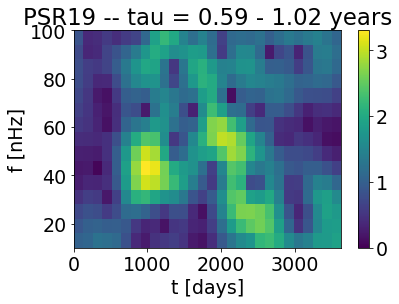

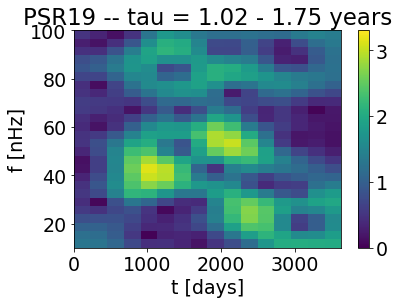

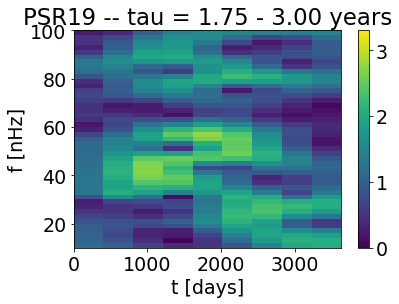

In [21]:
print(TS_all.keys())

tau_edges = TS_all['tau_edges']
T0_list = TS_all['t0_edges']
F0_list = TS_all['f0_edges']

for i in range(len(psrs)):
    print(i)
#     if i == 0:
#         continue
#     if i == 1:
#         continue
    tau_scan = TS_all['tau_scan'+str(i)]
    scan_max = max([np.nanmax(x) for x in tau_scan])
    print(scan_max)
#     if i == 0:
#         print(np.shape(F0_list[2]))
#         print(np.where(tau_scan[2]==tau_scan[2].max()))
#         print('Problematic T0: ', T0_list[2][8]/86400)
#         print('Problematic F0: ', F0_list[2][19])
    #print(np.max(tau_scan))
    for l in range(tau_edges.size-1):
#         print(i*(tau_edges.size-1)+l)
        fig = plt.figure(l+i*(tau_edges.size-1))
        #c = plt.gca().pcolormesh(t0s/24/3600, f0s/1e-9, tau_scan[l])#, vmax=np.max(tau_scan), vmin=0.0)
        c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
        plt.colorbar(c)
        #plt.plot(t0_true/24/3600, f0_true/1e-9, marker='x', ms=10, c='w')
        #plt.plot(t0_glitch/24/3600, f0_glitch/1e-9, marker='o', ms=10, c='xkcd:salmon')
        #plt.plot(t0_true2/24/3600, f0_true2/1e-9, marker='x', ms=10, c='w')
        plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
        plt.xlabel("t [days]")
        plt.ylabel("f [nHz]")

In [51]:
print('Problematic F0: ', F0_list[2][19])

Problematic F0:  [3.50000000e-09 8.09523810e-09 1.26904762e-08 1.72857143e-08
 2.18809524e-08 2.64761905e-08 3.10714286e-08 3.56666667e-08
 4.02619048e-08 4.48571429e-08 4.94523810e-08 5.40476190e-08
 5.86428571e-08 6.32380952e-08 6.78333333e-08 7.24285714e-08
 7.70238095e-08 8.16190476e-08 8.62142857e-08 9.08095238e-08
 9.54047619e-08 1.00000000e-07]


In [56]:
((T0_list[2][8]+T0_list[2][9])/86400)/2

1422.8723960313714

# Plotting wavelet tau scan

79.90084844686245
19
95
96
97
98
99


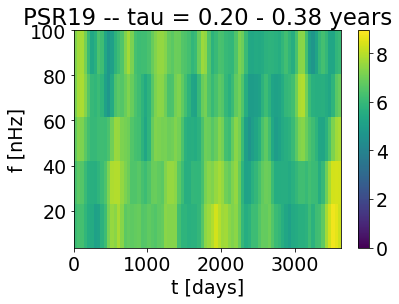

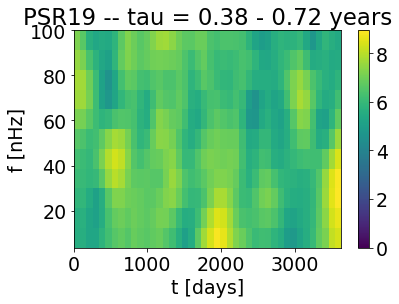

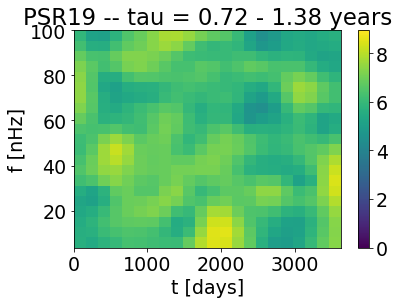

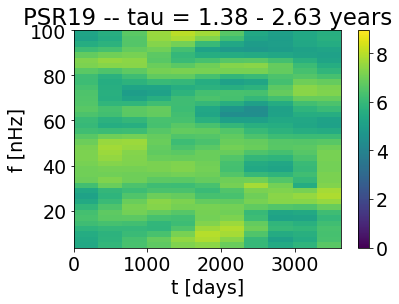

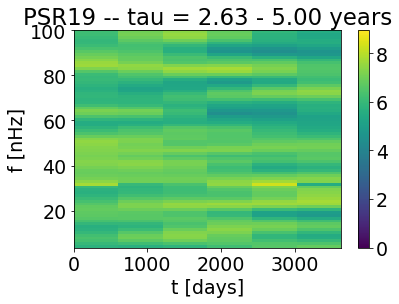

In [24]:
#print(i)

tau_edges = TS_dict['tau_edges']
T0_list = TS_dict['t0_edges']
F0_list = TS_dict['f0_edges']
tau_scan = TS_dict['tau_scan']
scan_max = max([np.nanmax(x) for x in tau_scan])
print(scan_max)
i = 19
print(i)
#print(np.max(tau_scan))
for l in range(tau_edges.size-1):
    print(i*(tau_edges.size-1)+l)
    fig = plt.figure(l+i*(tau_edges.size-1))
    #c = plt.gca().pcolormesh(t0s/24/3600, f0s/1e-9, tau_scan[l])#, vmax=np.max(tau_scan), vmin=0.0)
    c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
    plt.colorbar(c)
    #plt.plot(t0_true/24/3600, f0_true/1e-9, marker='x', ms=10, c='w')
    #plt.plot(t0_glitch/24/3600, f0_glitch/1e-9, marker='o', ms=10, c='xkcd:salmon')
    #plt.plot(t0_true2/24/3600, f0_true2/1e-9, marker='x', ms=10, c='w')
    plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
    plt.xlabel("t [days]")
    plt.ylabel("f [nHz]")

187.22256905591618
19
95
96
97
98
99


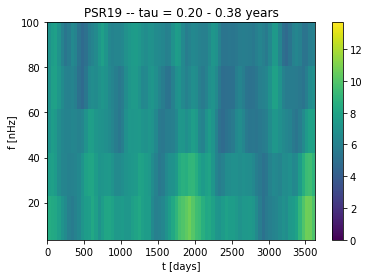

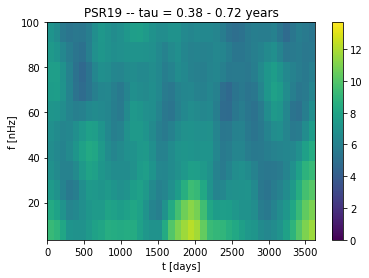

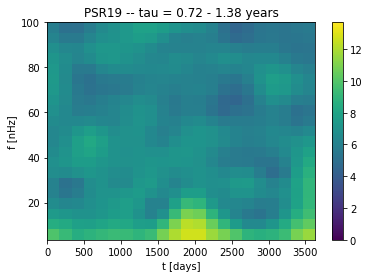

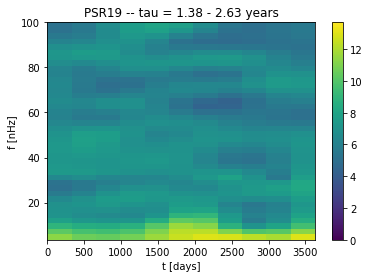

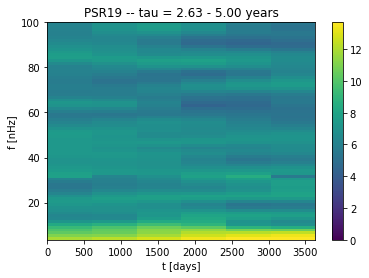

In [16]:
#print(i)

tau_edges = TS_dict['tau_edges']
T0_list = TS_dict['t0_edges']
F0_list = TS_dict['f0_edges']
tau_scan = TS_dict['tau_scan']
scan_max = max([np.nanmax(x) for x in tau_scan])
print(scan_max)
i = 19
print(i)
#print(np.max(tau_scan))
for l in range(tau_edges.size-1):
    print(i*(tau_edges.size-1)+l)
    fig = plt.figure(l+i*(tau_edges.size-1))
    #c = plt.gca().pcolormesh(t0s/24/3600, f0s/1e-9, tau_scan[l])#, vmax=np.max(tau_scan), vmin=0.0)
    c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
    plt.colorbar(c)
    #plt.plot(t0_true/24/3600, f0_true/1e-9, marker='x', ms=10, c='w')
    #plt.plot(t0_glitch/24/3600, f0_glitch/1e-9, marker='o', ms=10, c='xkcd:salmon')
    #plt.plot(t0_true2/24/3600, f0_true2/1e-9, marker='x', ms=10, c='w')
    plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
    plt.xlabel("t [days]")
    plt.ylabel("f [nHz]")